In [ ]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = './keypoint.csv'
model_save_path = './keypoint_classifier.hdf5'
tflite_save_path = './keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(63, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 63)                4032      
                                                                 
 dropout_1 (Dropout)         (None, 63)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2048      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
141/141 [==============================] - ETA: 0s - loss: 2.0655 - accuracy: 0.1718
Epoch 1: saving model to .\keypoint_classifier.hdf5
141/141 [==============================] - 1s 5ms/step - loss: 2.0655 - accuracy: 0.1718 - val_loss: 1.9929 - val_accuracy: 0.2437
Epoch 2/1000
140/141 [============================>.] - ETA: 0s - loss: 1.9925 - accuracy: 0.2103
Epoch 2: saving model to .\keypoint_classifier.hdf5
141/141 [==============================] - 0s 3ms/step - loss: 1.9926 - accuracy: 0.2105 - val_loss: 1.8745 - val_accuracy: 0.3049
Epoch 3/1000
127/141 [==========================>...] - ETA: 0s - loss: 1.8906 - accuracy: 0.2534
Epoch 3: saving model to .\keypoint_classifier.hdf5
141/141 [==============================] - 1s 5ms/step - loss: 1.8826 - accuracy: 0.2580 - val_loss: 1.6893 - val_accuracy: 0.4461
Epoch 4/1000
140/141 [============================>.] - ETA: 0s - loss: 1.7608 - accuracy: 0.3000
Epoch 4: saving model to .\keypoint_classifier.hdf5
141/141

In [12]:
def plot_loss_acc_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True)

  _ = ax1.plot(epochs, acc, 'bo', label='Training acc')
  _ = ax1.plot(epochs, val_acc, 'b', label='Validation acc')
  _ = ax1.set_title('Training and validation accuracy')
  _ = ax1.legend()

  _ = ax2.plot(epochs, loss, 'bo', label='Training loss')
  _ = ax2.plot(epochs, val_loss, 'b', label='Validation loss')
  _ = ax2.set_title('Training and validation loss')
  _ = ax2.legend()

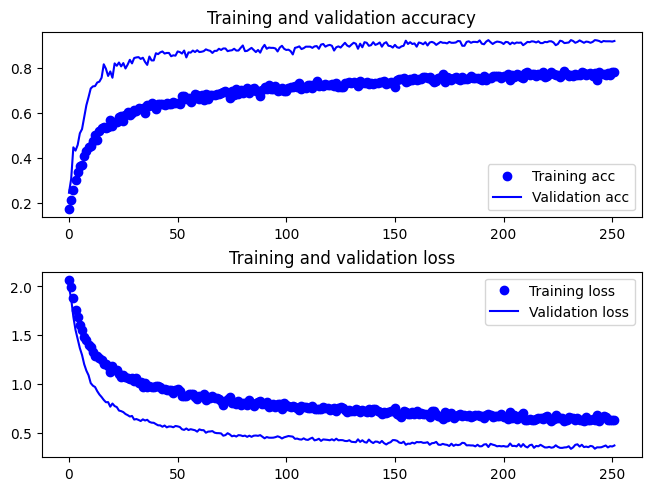

In [13]:
plot_loss_acc_curves(history)

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.9201


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 109ms/step
[6.9132383e-04 4.5421820e-02 5.5782907e-02 1.2395066e-03 8.3785871e-04
 8.9591253e-01 2.7710963e-05 8.6289554e-05]
5


# Confusion matrix

24/24 [==============================] - 0s 1ms/step


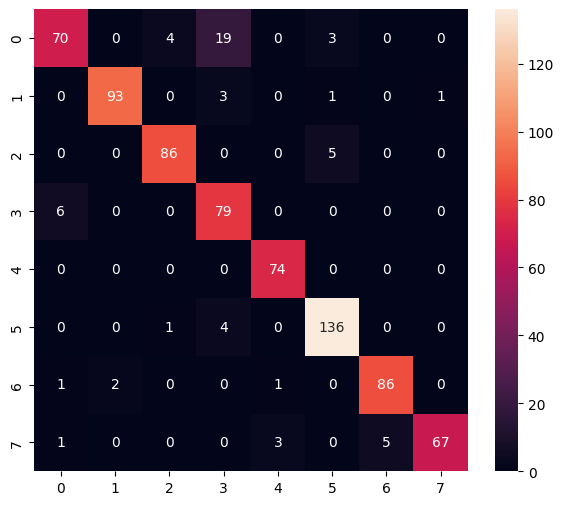

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.73      0.80        96
           1       0.98      0.95      0.96        98
           2       0.95      0.95      0.95        91
           3       0.75      0.93      0.83        85
           4       0.95      1.00      0.97        74
           5       0.94      0.96      0.95       141
           6       0.95      0.96      0.95        90
           7       0.99      0.88      0.93        76

    accuracy                           0.92       751
   macro avg       0.92      0.92      0.92       751
weighted avg       0.92      0.92      0.92       751



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [19]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\moham\AppData\Local\Temp\tmp1wkpudgr\assets


11648

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.7881029e-04 4.6441291e-02 5.6904994e-02 1.2025737e-03 8.3905621e-04
 8.9381963e-01 2.7561988e-05 8.6066386e-05]
5
